# Predicting Game Newsletter Subscription Using K-Nearest Neighbors

## Introduction
The purpose of this data science project is to analyze and predict player behaviours on a Minecraft server based on data collected by a UBC Computer Science research group. This data consisted of two primary files: players.csv and sessions.csv. The players.csv file included detailed information about each player, such as their age, experience level, email, and other personal traits. The sessions.csv file tracked individual play sessions for each player based on their email, including data on session times. 



### Research Question

**What player characteristics and behaviors are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?**

The specific question we addressed in this project is: 
By analyzing both the age and the experience level of a player, we will build a predictive model (K-NN Classification) to assess the likelihood of player subscribing to the newsletter based on such characteristics.


To answer this question, we focus solely on using the players.csv dataset file, as it includes the relevant characteristics (age and experience level) we will be using to hypothesize a player's subscription behaviour. This will involve exploring the dataset to understand the relationships between these variables and subscription status, followed by the development and assessment of the accuracy of our model to form predictions. 



### Dataset Description

The dataset contains 196 observations with the following variables:

- `experience`: Player experience level (Pro, Veteran, Regular, Amateur)
- `subscribe`: Whether the player subscribed to the newsletter
- `played_hours`: Total hours played
- `Age`: Player's age
- `gender`: Player's gender
- `hashedEmail` and `name`: Removed for irrelevance

This analysis uses techniques covered in the DSCI 100 course including data wrangling, visualization, and K-Nearest Neighbors classification.


**Our goal was to predict whether a player would subscribe to a game newsletter based on a set of player's features. Since the response variable (subscribe) is binary (TRUE/FALSE), we framed this as a classification problem.**

**We selected the K-Nearest Neighbors (KNN) algorithm because it is non-parametric, easy to understand, and directly influenced by the similarity between features. This cooperates well with our small dataset and helps build an easy understanding of how different features impact prediction outcomes.**

**Because our predictors are categorical variables, we performed one-hot encoding to convert them into a numerical format to be used for the KNN algorithm.**

**Before modeling, we prepared the dataset as follows:**

Removed unnecessary variables (name, hashedEmail)
Converted categorical variables into numeric values:
experience: Pro = 3, Veteran = 2, Regular = 1, Amateur = 0
gender: Male = 1, Others = 0
Transformed logical subscribe column to numeric (1 or 0)
Removed rows with missing values using drop_na()



In [157]:
library(tidyverse)
library(class)
library(caret)
library(lubridate)
library(ggplot2)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 20)
library(recipes)
library(themis)


In [152]:
# Reading players.csv file

players <- read_csv("players.csv") 

players_clean <- players |>
    select(-hashedEmail, -name) |>
    mutate(subscribe = as.factor(subscribe)) |>
    na.omit()


head(players_clean)


Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,played_hours,gender,Age
<chr>,<fct>,<dbl>,<chr>,<dbl>
Pro,TRUE,30.3,Male,9
Veteran,TRUE,3.8,Male,17
Veteran,FALSE,0.0,Male,17
Amateur,TRUE,0.7,Female,21
Regular,TRUE,0.1,Male,21
Amateur,TRUE,0.0,Female,17


Upon inspecting the file, we observed that the number of subscribers exceeds the number of non-subscribers. To verify this, we created a table to compare the counts of each group. As shown below, 73% are subscribers, while 27% are non-subsribers. Given this class imbalance, we will upsample the response variable once we build the model to ensure a more balanced representation.

In [175]:
num_obs <- nrow(players)

players_subscribe <- players |>
  group_by(subscribe) |>
  summarize(
    count = n(),
    percentage = n() / num_obs * 100
  )

players_subscribe

subscribe,count,percentage
<lgl>,<int>,<dbl>
FALSE,52,26.53061
TRUE,144,73.46939


We then summarized numeric features to understand their scale and variance (e.g., max, min, mean).

In [120]:
players_clean |> 
  summarise(
    max_hours = max(played_hours),
    min_hours = min(played_hours),
    mean_hours = mean(played_hours),
    max_age = max(Age),
    min_age = min(Age),
    mean_age = mean(Age)
  )


max_hours,min_hours,mean_hours,max_age,min_age,mean_age
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
223.1,0,5.904639,50,8,20.52062


### **Findings on Player Type Differences**  

We visualized three relationships:

- Subscription Rate by Experience Level

- Played Hours vs Subscription

- Age Distribution vs Subscription


Based on the visualizations generated, we can analyze the vary in characteristics and how these factors influence **subscription behaviour**.

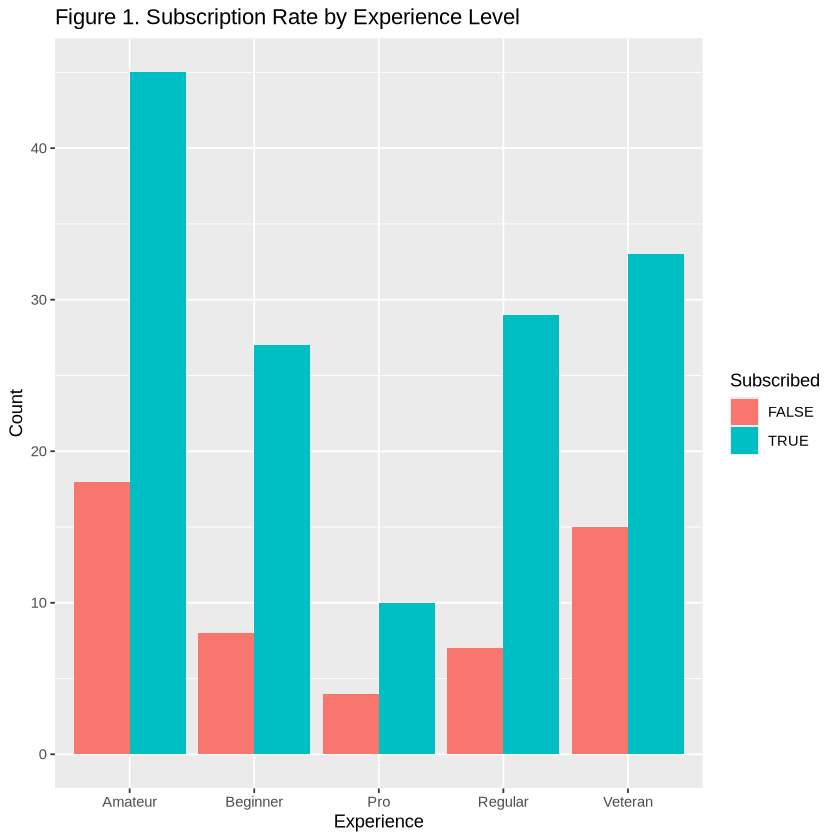

In [79]:
ggplot(players, aes(x = experience, fill = subscribe)) +
  geom_bar(position = "dodge") +
  labs(title = "Figure 1. Subscription Rate by Experience Level", x = "Experience", y = "Count", fill = "Subscribed")


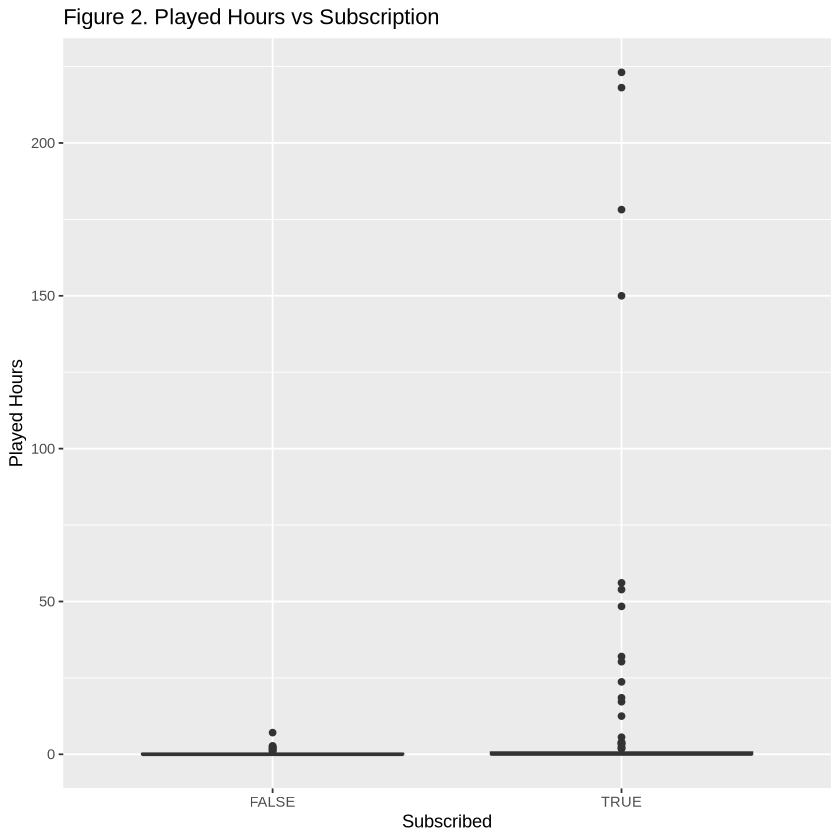

In [81]:
ggplot(players, aes(x = subscribe, y = played_hours)) +
  geom_line() +
  labs(
    title = "Figure 2. Played Hours vs Subscription",
    x = "Subscribed",
    y = "Played Hours"
  )


Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


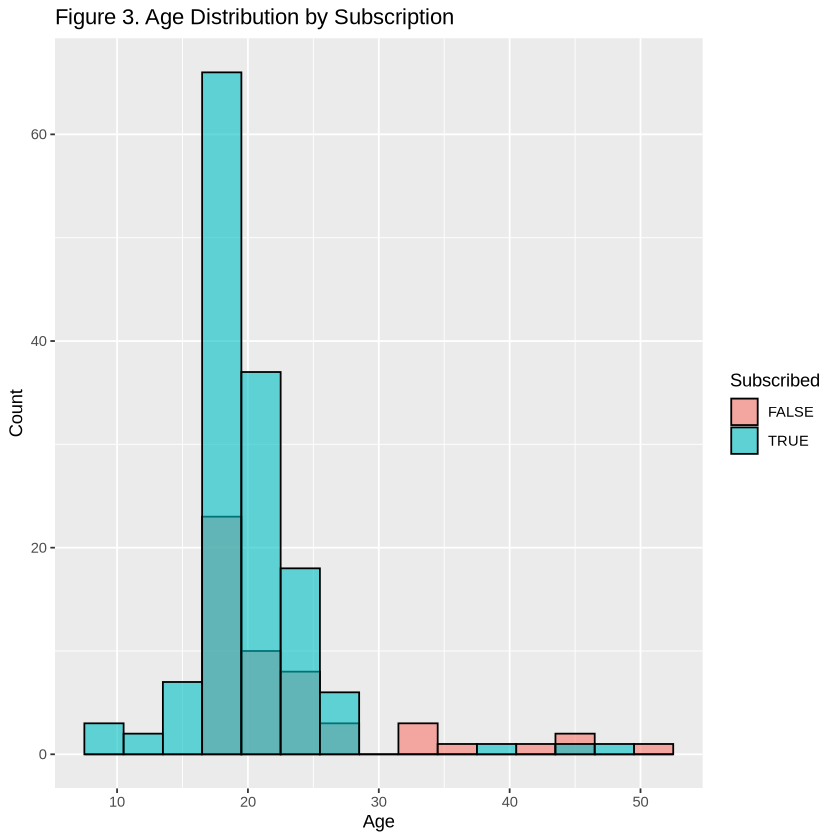

In [84]:
ggplot(players, aes(x = Age, fill = subscribe)) +
  geom_histogram(bins = 15, alpha = 0.6, position = "identity", color = "black") +
  labs(title = "Figure 3. Age Distribution by Subscription", x = "Age", y = "Count", fill = "Subscribed")

In [176]:
# ggplot(players, aes(x = gender, fill = factor(subscribe))) +
#   geom_bar(position = "fill") +
#   labs(
#     title = "Figure 4. Subscription Proportion by Gender",
#     x = "Gender",
#     y = "Proportion",
#     fill = "Subscribed"
#   )


#### **1 Experience Level vs Subscription Rate**
- Pro and Veteran players have the highest subscription rates, while Regular and Amateur players have lower subscription rates.

#### **2 Played Hours vs Subscription**
- Subscribed players tend to have higher median played hours.


#### **3 Age vs Subscription**
- Younger players are more likely to subscribe, at same time older players (above 30) show a lower subscription rate.

- Older players may focus on the playing alone


#### **4 Gender vs Subscription**
- Male players have a slightly higher subscription rate than female players, but overall, gender plays a slight effect on subscription behavior.

### **Training the Model (edit this later)**  

We split the dataset into training and test sets using an 80/20 ratio in initial_split(). We used the scale() function to normalize numerical predictors to ensure they are on comparable scales, which is essential for KNN performance.

In [177]:
set.seed(123)

players_split <- initial_split(players_clean, prop = 0.80, strata = subscribe)

players_train <- training(players_split)

players_test <- testing(players_split)

glimpse(players_train)

Rows: 154
Columns: 5
$ experience   <chr> "Amateur", "Amateur", "Veteran", "Amateur", "Veteran", "B…
$ subscribe    <fct> FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, F…
$ played_hours <dbl> 0.0, 0.1, 0.0, 0.0, 1.4, 0.0, 0.0, 0.9, 0.0, 0.1, 0.2, 0.…
$ gender       <chr> "Male", "Female", "Male", "Prefer not to say", "Prefer no…
$ Age          <dbl> 22, 17, 23, 33, 25, 24, 23, 18, 42, 22, 37, 28, 23, 17, 1…


Created recipe

In [178]:

players_recipe <- recipe(subscribe ~ Age + experience + played_hours, data = players_clean) |>
    step_dummy(experience) |> # To turn into numeric binary model terms
    step_upsample(subscribe) |>  # To upsample subscribers
    step_scale(all_predictors()) |>
    step_center(all_predictors())

players_recipe
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
    set_engine("kknn") |>
    set_mode("classification")





── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 3



── Operations 

• Dummy variables from: experience

• Up-sampling based on: subscribe

• Scaling for: all_predictors()

• Centering for: all_predictors()



Found best k-value

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
10,accuracy,binary,0.5521569,10,0.03540312,Preprocessor1_Model01
10,roc_auc,binary,0.5321402,10,0.05017453,Preprocessor1_Model01
11,accuracy,binary,0.5588235,10,0.04065760,Preprocessor1_Model02
11,roc_auc,binary,0.5392992,10,0.05464219,Preprocessor1_Model02
12,accuracy,binary,0.5650735,10,0.03903330,Preprocessor1_Model03
12,roc_auc,binary,0.5541856,10,0.05658316,Preprocessor1_Model03
13,accuracy,binary,0.5438725,10,0.04433361,Preprocessor1_Model04
13,roc_auc,binary,0.5630871,10,0.06083712,Preprocessor1_Model04
14,accuracy,binary,0.5501225,10,0.04408625,Preprocessor1_Model05


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
10,accuracy,binary,0.5521569,10,0.03540312,Preprocessor1_Model01
11,accuracy,binary,0.5588235,10,0.04065760,Preprocessor1_Model02
12,accuracy,binary,0.5650735,10,0.03903330,Preprocessor1_Model03
13,accuracy,binary,0.5438725,10,0.04433361,Preprocessor1_Model04
14,accuracy,binary,0.5501225,10,0.04408625,Preprocessor1_Model05
15,accuracy,binary,0.5383578,10,0.05376874,Preprocessor1_Model06
16,accuracy,binary,0.5312745,10,0.05189400,Preprocessor1_Model07
17,accuracy,binary,0.5375735,10,0.03765980,Preprocessor1_Model08
18,accuracy,binary,0.5685539,10,0.05034984,Preprocessor1_Model09


[1] 18

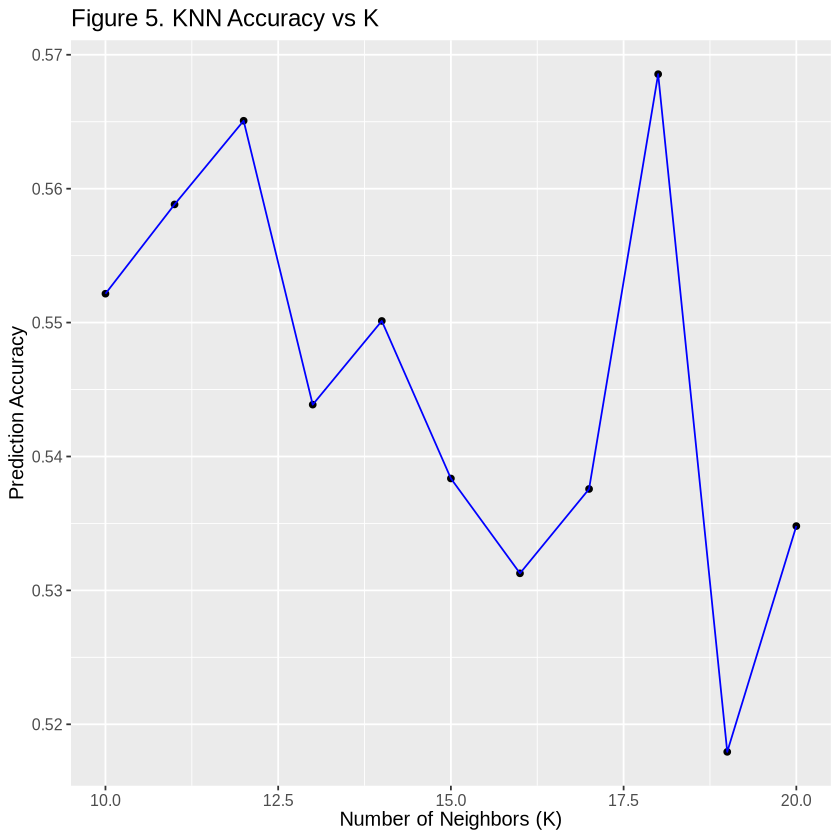

In [179]:
set.seed(2020) # DO NOT REMOVE


players_vfold <- vfold_cv(players_train, v = 10, strata = subscribe)


players_vfold_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(knn_spec) |>
    fit_resamples(resamples = players_vfold)


players_metrics <- collect_metrics(players_vfold_fit)


knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 10, to = 20, by = 1))

knn_results <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = players_vfold, grid = k_vals) |>
    collect_metrics()

knn_results

accuracies <- knn_results |>
  filter(.metric == "accuracy")

accuracies
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line(color = "blue") +
  labs(
    title = "Figure 5. KNN Accuracy vs K",
    x = "Number of Neighbors (K)",
    y = "Prediction Accuracy"
  ) +
  theme(text = element_text(size = 12))

accuracy_vs_k

best_k <- accuracies |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)
best_k

We tested K values from 1 to 20 and calculated test accuracy for each value. The result was plotted as Figure 5, showing how model performance varies with K.

We selected the value of 15 as the best k value.

In [180]:

# Creating model
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(knn_spec) |>
  fit(data = players_train)

knn_fit



══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
4 Recipe Steps

• step_dummy()
• step_upsample()
• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(18,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.3539823
Best kernel: rectangular
Best k: 18

In [181]:
players_test_predictions <- predict(knn_fit, players_test) |>
  bind_cols(players_test)

players_test_predictions 


.pred_class,experience,subscribe,played_hours,gender,Age
<fct>,<chr>,<fct>,<dbl>,<chr>,<dbl>
TRUE,Veteran,TRUE,3.8,Male,17
TRUE,Veteran,FALSE,0.0,Male,17
TRUE,Amateur,FALSE,0.0,Male,21
FALSE,Amateur,TRUE,48.4,Female,17
FALSE,Regular,TRUE,0.3,Male,8
TRUE,Veteran,FALSE,0.1,Male,18
TRUE,Beginner,TRUE,0.6,Male,26
FALSE,Regular,TRUE,5.6,Male,17
FALSE,Amateur,TRUE,0.2,Male,27


In [184]:
players_test_predictions |>
  metrics(truth = subscribe, estimate = .pred_class) |>
  filter(.metric == "accuracy")

players_test_predictions |>
    precision(truth = subscribe, estimate = .pred_class, event_level="first")

players_test_predictions |>
    recall(truth = subscribe, estimate = .pred_class, event_level="first")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.5


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.1538462


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.1818182


In [185]:
confusion <- players_test_predictions |>
             conf_mat(truth = subscribe, estimate = .pred_class)
confusion

          Truth
Prediction FALSE TRUE
     FALSE     2   11
     TRUE      9   18

## Discussion
**Figure 1: Subscription Rate by Experience Level**

Analysis:
The plot clearly shows that players with higher experience levels (Veteran and Pro) have higher subscription rates than Regular or Amateur players. This supports the assumption that more experienced players are more engaged with the game and thus more likely to subscribe. What's more, it may also reflect that experienced players have been in the game longer and had more possibility to see the newsletter option.

 **Figure 2: Played Hours vs Subscription (Boxplot)**

Analysis :
The boxplot indicates that subscribed players tend to have higher median and maximum playtime. This seems intuitive—more invested players may want to stay updated. However, it’s also possible that subscription leads to more engagement over time (reverse causality)

**Figure 3:Age Distribution by Subscription**

Analysis :
Younger players appear more likely to subscribe. This may reflect digital habits: younger users tend to be more open to email subscriptions, and more accustomed to in-game notifications and marketing. Oppoesitely, it may be that older users are less willing o accpect                                                                 

**Figure 4: Subscription Count by Gender**

Analysis :
There is a small difference in subscription counts between male and non-male players. However, the difference is minor and may not be statistically meaningful. 

These results mostly align with our expectations. It’s true that highly engaged players—those who play longer or identify as experienced—are more likely to subscribe. These players may have a greater emotional investment in the game, and thus are more interested in receiving updates and special content. The limited effect of gender was also expected, as gender is often a weak predictor unless the product is gender-targeted.

These findings can help game developers better understand user behavior. For example, promotional efforts could be tailored to high-playtime players to increase conversions. Knowing that experience and age influence subscription likelihood, marketing emails could highlight tips, achievements, or community events to attract younger or more engaged players.Furthermore,The game team could also consider promoting newsletter subscriptions through platforms like Instagram and TikTok, which are more popular among younger audiences.

## Project Limitations and Improvements
**Sample Size**: With only 196 players in the dataset, the sample may not be sufficiently representative of the overall player population. In particular, certain groups of people (e.g., older players, non-male genders, or very casual users) may be underrepresented, potentially biasing the model’s conclusions. Expanding the dataset with more diverse and balanced samples would improve the robustness and generalizability of the findings.

**Feature Limitation**: The model currently relies on a limited set of variables: age, gender, experience, and total playtime. These features, while relevant, provide only a static snapshot of user behavior. Incorporating dynamic behavioral indicators such as login frequency, session duration, recent activity, or interaction with in-game content could significantly enhance predictive power. Behavioral features often capture intent and engagement more effectively than static demographics.

**Platform Bias**: The dataset does not capture from which channels players encountered or accessed the subscription option. Players who engage primarily via mobile or social platforms might behave differently. Future data collection could include interaction channels to analyze cross-platform behavior differences.